In [1088]:
# dataset https://www.kaggle.com/marksman/us-adult-income-salary-prediction/data

In [1089]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
#from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import norm
from openml import tasks, flows, runs, datasets, config
import random
from sklearn.pipeline import Pipeline
import pandasql as psql
import tensorflow as tf
from tensorflow import keras

train = pd.read_csv("train.csv")
train.salary.unique()

array([' <=50K', ' >50K'], dtype=object)

In [1090]:
def preprocess(df):
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(lambda x: x.strip())
    
    df["salary"] = df["salary"].apply(lambda x: int(x == "<=50K"))
    df["salary"] = pd.to_numeric(df["salary"])

    df["sex"] = df["sex"].apply(lambda x: int(x == "Male"))
    df["sex"] = pd.to_numeric(df["sex"])

    return df

train = preprocess(train)

<AxesSubplot:>

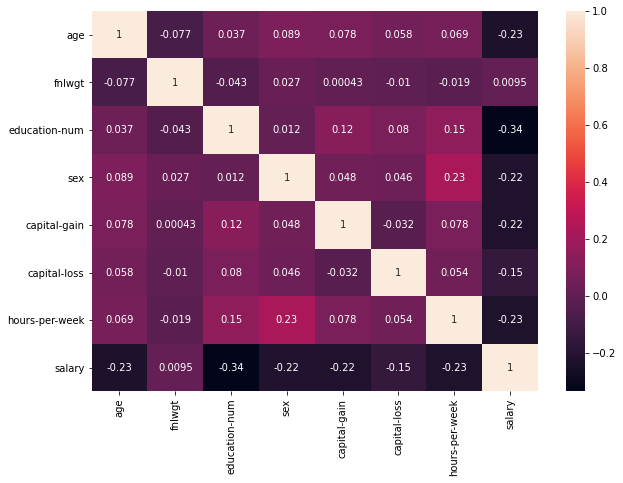

In [1091]:

import seaborn as sn
plt.figure(figsize = (10,7))
corr = train.corr()
sn.heatmap(corr, annot=True)

In [1092]:
def removeOutlier(df):
    columns = ["age", "hours-per-week", "fnlwgt"]

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_lmt = Q1 - 1.5 * IQR
        upper_lmt = Q3 + 1.5 * IQR
        
        df = df[(df[col] > lower_lmt) & (df[col] < upper_lmt)]

    return df

In [1093]:
train1 = removeOutlier(train)

In [1094]:
# for col in train1.columns:
#     if train1[col].dtype == "object":
#         print("{}: {}".format(col, train1[col].unique()))

In [1095]:
def featureEngineering(df):
    # working on the columns with two values
    remObj = ['?', '1st-4th', 'Married-civ-spouse', '?', 'Unmarried', 'Other', '?']
    lst = []

    index = 0

    for col in df.columns:
        if df[col].dtype == "object":
            dummies = pd.get_dummies(df[col])
            df = pd.concat([df,dummies], axis="columns")
            df = df.drop([col,remObj[index]], axis="columns")
            index += 1
    
    return df

train2 = featureEngineering(train1)
train2[:10]

# male -> 0
# female -> 1

# <= 50 -> 0
# > 50 -> 1

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,salary,Federal-gov,Local-gov,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,39,77516,13,1,2174,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,1,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,37,284582,14,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,52,209642,9,1,0,0,45,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,31,45781,14,0,14084,0,50,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,42,159449,13,1,5178,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11,30,141297,13,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,32,205019,12,1,0,0,50,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [1096]:
X = train2.drop(["salary"], axis="columns")
y = train2["salary"]

In [1097]:
y.unique()

array([1, 0], dtype=int64)

In [1098]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

y.value_counts()

1    16933
0    16933
Name: salary, dtype: int64

In [1099]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [1100]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [1101]:
x_train.shape

(27092, 100)

In [1102]:
# model = RandomForestClassifier()
# model.fit(x_train,y_train)

model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(28,28)), # flattening the data
    keras.layers.Dense(25, input_shape=(100,), activation="relu"), # making hidden layer
    keras.layers.Dense(5, activation="relu"), # making output layer
    keras.layers.Dense(1, activation="sigmoid"), # making output layer
])

model.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=["accuracy"],
)

# tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
847/847 [==============================] - 3s 2ms/step - loss: 0.3249 - accuracy: 0.8600
Epoch 2/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2509 - accuracy: 0.8862
Epoch 3/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2390 - accuracy: 0.8906
Epoch 4/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2341 - accuracy: 0.8928
Epoch 5/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2291 - accuracy: 0.8948
Epoch 6/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2268 - accuracy: 0.8954
Epoch 7/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2238 - accuracy: 0.8975
Epoch 8/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2225 - accuracy: 0.8982
Epoch 9/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2207 - accuracy: 0.8981
Epoch 10/10
847/847 [==============================] - 2s 2ms/step - loss: 0.2185 - accuracy: 0.8997

In [1103]:
x_test = scaler.transform(x_test)
model.evaluate(x_test,y_test)

212/212 [==============================] - 1s 1ms/step - loss: 0.2381 - accuracy: 0.8875


[0.23810090124607086, 0.8875110745429993]

In [1104]:
y_predicted = model.predict(x_test)
y_predicted = [(i[0] > 0.5) for i in y_predicted]

Text(69.0, 0.5, 'Truth')

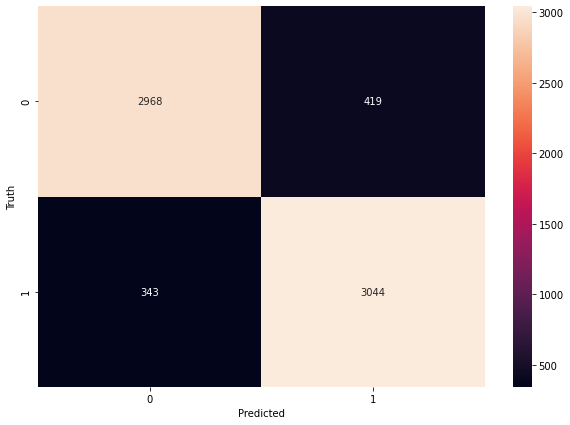

In [1105]:
cm = tf.math.confusion_matrix(y_test, y_predicted)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [1106]:
# artifacts

col_index = {"age": 0, "fnlwgt": 1, "education-num": 2, "sex": 3, "capital-gain": 4, "capital-loss": 5, "hours-per-week": 6, "Federal-gov": 7, "Local-gov": 8, "Never-worked": 9, "Private": 10, "Self-emp-inc": 11, "Self-emp-not-inc": 12, "State-gov": 13, "Without-pay": 14, "10th": 15, "11th": 16, "12th": 17, "5th-6th": 18, "7th-8th": 19, "9th": 20, "Assoc-acdm": 21, "Assoc-voc": 22, "Bachelors": 23, "Doctorate": 24, "HS-grad": 25, "Masters": 26, "Preschool": 27, "Prof-school": 28, "Some-college": 29, "Divorced": 30, "Married-AF-spouse": 31, "Married-spouse-absent": 32, "Never-married": 33, "Separated": 34, "Widowed": 35, "Adm-clerical": 36, "Armed-Forces": 37, "Craft-repair": 38, "Exec-managerial": 39, "Farming-fishing": 40, "Handlers-cleaners": 41, "Machine-op-inspct": 42, "Other-service": 43, "Priv-house-serv": 44, "Prof-specialty": 45, "Protective-serv": 46, "Sales": 47, "Tech-support": 48, "Transport-moving": 49, "Husband": 50, "Not-in-family": 51, "Other-relative": 52, "Own-child": 53, "Wife": 54, "Amer-Indian-Eskimo": 55, "Asian-Pac-Islander": 56, "Black": 57, "White": 58, "Cambodia": 59, "Canada": 60, "China": 61, "Columbia": 62, "Cuba": 63, "Dominican-Republic": 64, "Ecuador": 65, "El-Salvador": 66, "England": 67, "France": 68, "Germany": 69, "Greece": 70, "Guatemala": 71, "Haiti": 72, "Holand-Netherlands": 73, "Honduras": 74, "Hong": 75, "Hungary": 76, "India": 77, "Iran": 78, "Ireland": 79, "Italy": 80, "Jamaica": 81, "Japan": 82, "Laos": 83, "Mexico": 84, "Nicaragua": 85, "Outlying-US(Guam-USVI-etc)": 86, "Peru": 87, "Philippines": 88, "Poland": 89, "Portugal": 90, "Puerto-Rico": 91, "Scotland": 92, "South": 93, "Taiwan": 94, "Thailand": 95, "Trinadad&Tobago": 96, "United-States": 97, "Vietnam": 98, "Yugoslavia": 99,}

workclass = ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']

education = ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', 'Preschool', '12th', 'Some-college']

education_num = {'Bachelors': 13, 'HS-grad': 9, '11th': 7, 'Masters': 14, '9th': 5, 'Some-college': 10, 'Assoc-acdm': 12, 'Assoc-voc': 11, '7th-8th': 4, 'Doctorate': 16, 'Prof-school': 15, '5th-6th': 3, '10th': 6, '1st-4th': 2, 'Preschool': 1, '12th': 8}

martialStatus = ['Never-married', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed']

occupation = ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv']

relationship = ['Not-in-family', 'Husband', 'Wife', 'Own-child',
       'Other-relative']

race = ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo'],

native_country = ['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands']


In [1112]:
def predicter(age, workclass, fnlwgt, education, maritalStatus, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country):
    x = np.zeros(100)
    sex = int(sex == "male")
    
    x[0] = age
    
    try:
        x[col_index[workclass]] = 1
    except:
        pass

    x[1] = fnlwgt

    try:
        x[2] = education_num[education]
    except:
        pass
    
    try:
        x[col_index[maritalStatus]] = 1
    except:
        pass
    
    try:
        x[col_index[occupation]] = 1
    except:
        pass
  
    try:
        x[col_index[relationship]] = 1
    except:
        pass

    try:
        x[col_index[race]] = 1
    except:
        pass

    x[3] = sex
    x[4] = capital_gain
    x[5] = capital_loss
    x[6] = hours_per_week

    try:
        x[col_index[native_country]] = 1
    except:
        pass

    x = scaler.transform([x])
    return int(model.predict(x)[0][0] > 0.5)

predicter(39,"State-gov",77516,"Bachelors", "Never-married", "Adm-clerical", "Not-in-family", "white", "Male", 2174, 0, 40, "India")

1

In [1113]:
# age, workclass, fnlwgt, education, maritalStatus, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country
test = pd.read_csv("test.csv")

y_predicted = []

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = test[col].apply(lambda x: x.split())

for index, row in test.iterrows():
    print(predicter(row["age"], row["workclass"], row["fnlwgt"], row["education"], row["marital-status"], row["occupation"], row["relationship"], row["race"], row["sex"], row["capital-gain"], row["capital-loss"], row["hours-per-week"], row["native-country"]))
    break

y_predicted

0


[]

In [1114]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [1115]:
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [1116]:
import json
with open("colIndex.json", "w") as f:
    f.write(json.dumps(col_index))

In [1117]:
with open("workClass.json", "w") as f:
    f.write(json.dumps(workclass))

In [1118]:
with open("education.json", "w") as f:
    f.write(json.dumps(education))

In [1119]:
with open("education_num.json", "w") as f:
    f.write(json.dumps(education_num))

In [1120]:
with open("maritalStatus.json", "w") as f:
    f.write(json.dumps(martialStatus))

In [1121]:
with open("occupation.json", "w") as f:
    f.write(json.dumps(occupation))

In [1122]:
with open("relationship.json", "w") as f:
    f.write(json.dumps(relationship))

In [1123]:
with open("race.json", "w") as f:
    f.write(json.dumps(race))

In [ ]:
with open("native_country.json", "w") as f:
    f.write(json.dumps(native_country))